**Background:**

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

<img src="mobile.png" width=400 height=400 />

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor. 

**Data Description:**

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Goal(s):**

Predict if the page is being flipped using a single image.

**Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

**Bonus(es):**

Predict if a given sequence of images contains an action of flipping.

**Load the Data in Fastai and Exploring it**

In [1]:
import os
from fastai import *
from fastai.vision import *

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

from math import floor
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.listdir("images/training")
train_path = "images/training"
test_path = "images/testing"

In [3]:
def get_classes(file_path): 
    dir_name = os.path.dirname(file_path)
    split_dir_name = dir_name.split("/")
    dir_levels = len(split_dir_name)
    label  = split_dir_name[dir_levels - 1]
    return(label)

In [4]:
from glob import glob
imagePatches = glob("images/training/*/*.*", recursive=True)
imagePatches[0:10]

['images/training/notflip/0048_000000028.jpg',
 'images/training/notflip/0033_000000029.jpg',
 'images/training/notflip/0024_000000016.jpg',
 'images/training/notflip/0041_000000023.jpg',
 'images/training/notflip/0048_000000012.jpg',
 'images/training/notflip/0029_000000024.jpg',
 'images/training/notflip/0057_000000024.jpg',
 'images/training/notflip/0034_000000016.jpg',
 'images/training/notflip/0030_000000015.jpg',
 'images/training/notflip/0021_000000023.jpg']

In [5]:
path=""
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0.10, max_zoom=1.5, max_warp=0.2, max_lighting=0.2,
                     xtra_tfms=[(symmetric_warp(magnitude=(-0,0), p=0)),]) 

In [6]:
data = ImageDataBunch.from_name_func(path, imagePatches, label_func=get_classes,size=420, 
                                     bs=4,num_workers=2,test = test_path,ds_tfms=tfms
                                  ).normalize(imagenet_stats)

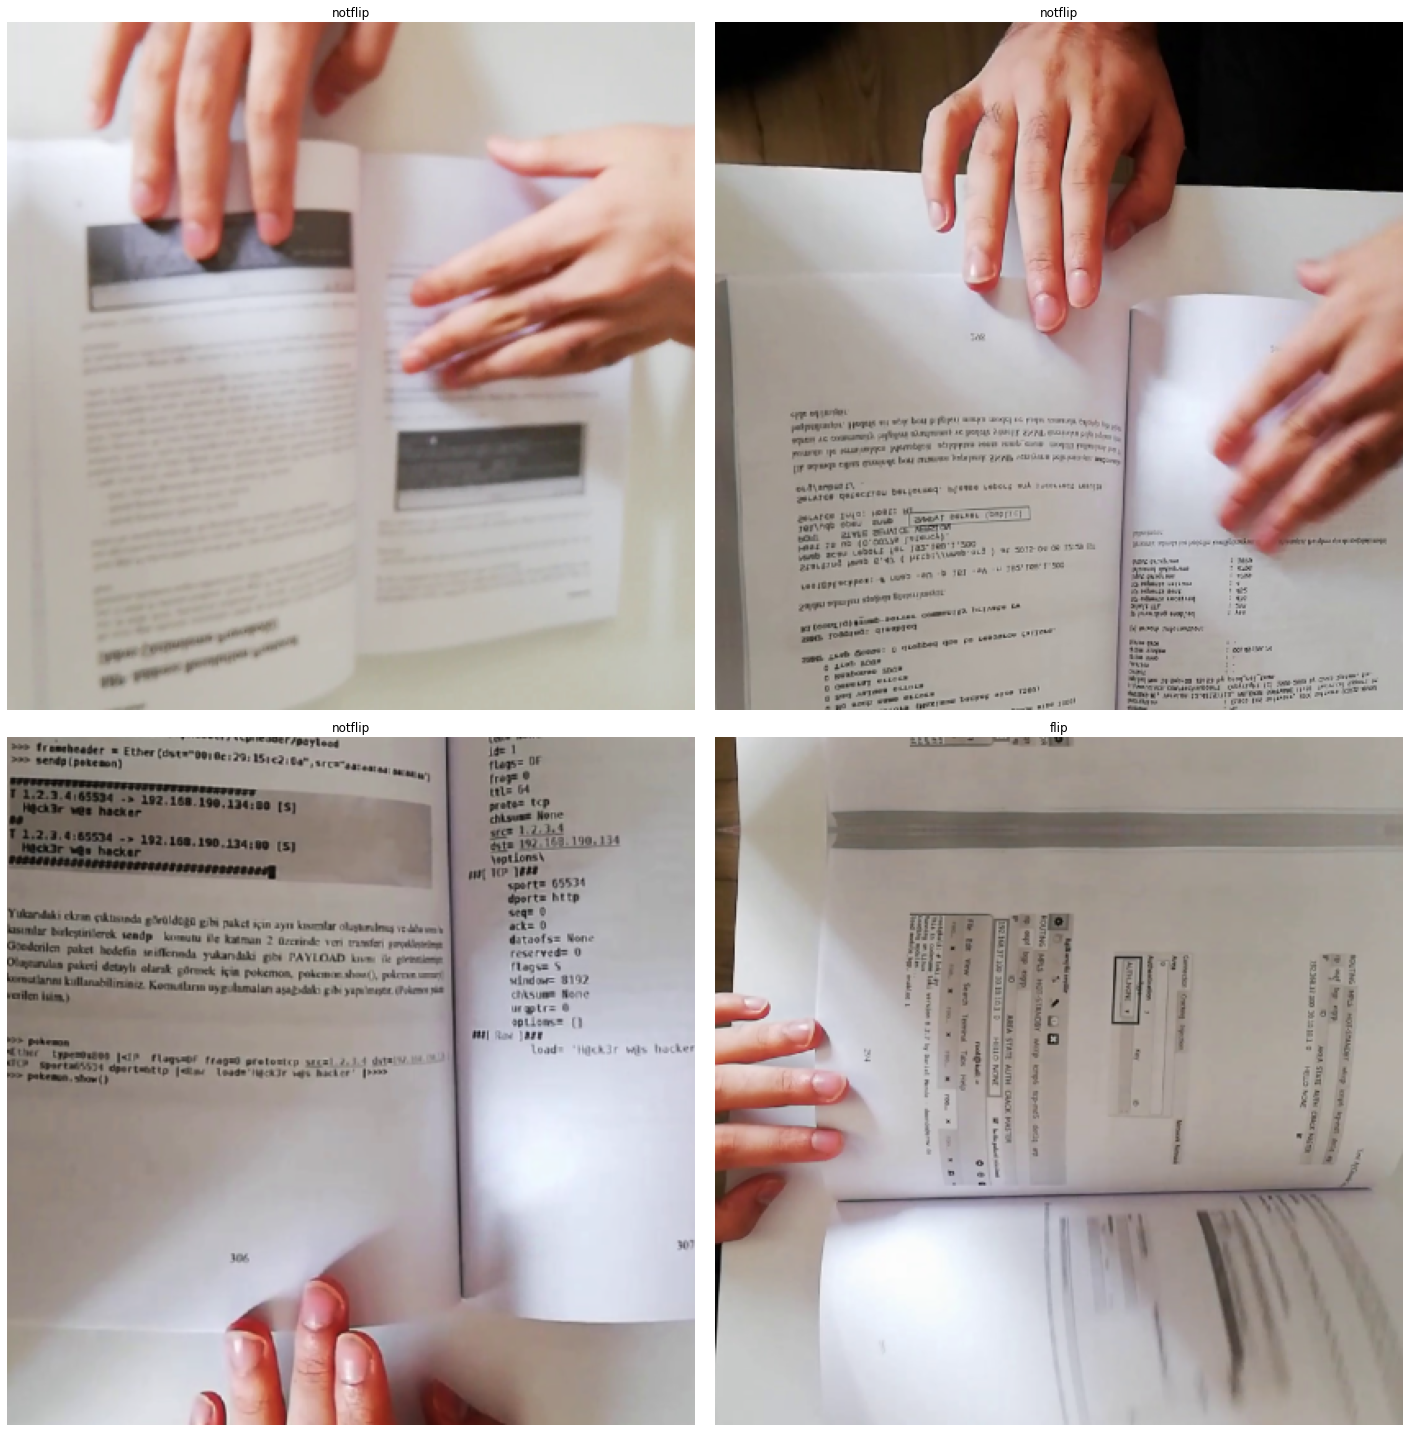

In [7]:
data.show_batch(rows=5, figsize=(20,20))

**Training: use pretrained architecture**

In [8]:
learner= cnn_learner(data, models.resnet101,metrics=[accuracy],bn_final=True,opt_func=optim.Adamax,ps = 0.25,model_dir='/tmp/models/')


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


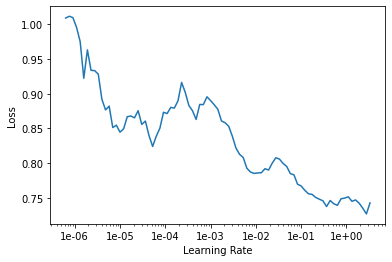

In [9]:
learner.lr_find()
learner.recorder.plot()

In [10]:
lr=1e-1
learner.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.629121,0.547693,0.792887,50:21


In [11]:
learner.save('model-1')

In [12]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


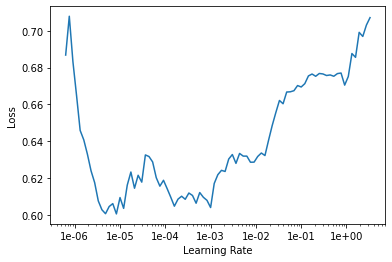

In [13]:
learner.lr_find()
learner.recorder.plot()

In [14]:
learner.load('model-1')
learner.fit_one_cycle(10, slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.580323,0.527716,0.822176,46:34
1,0.582019,0.534884,0.711297,46:48
2,0.533695,0.495133,0.790795,45:39
3,0.538976,0.434068,0.868201,46:04
4,0.505268,0.466670,0.853557,52:04
5,0.456682,0.393702,0.914226,56:23
6,0.442777,0.345751,0.922594,56:23
7,0.458282,0.341059,0.924686,51:57
8,0.480834,0.309750,0.939331,52:18
9,0.430844,0.321739,0.924686,57:11


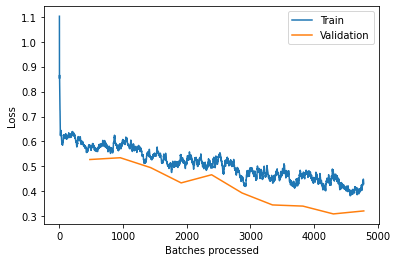

In [15]:
learner.recorder.plot_losses()

In [16]:
learner.validate()

[0.32173917, tensor(0.9247)]

In [17]:
interp = ClassificationInterpretation.from_learner(learner)

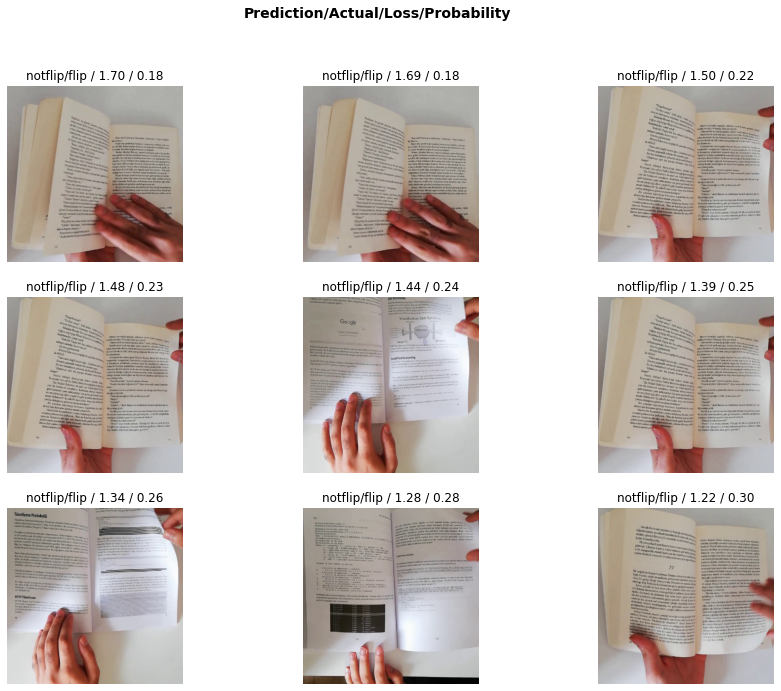

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
interp.most_confused(min_val=2)

[('flip', 'notflip', 36)]

In [20]:
preds,y = learner.TTA(ds_type=DatasetType.Test)